In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
#Tensorflow datasets
dataset=tfds.builder('cats_vs_dogs')

In [4]:
dataset.info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [6]:
dataset.info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [7]:
class_names=[]
for i in range(dataset.info.features['label'].num_classes):
  class_names.append(dataset.info.features['label'].int2str(i))

In [8]:
class_names

['cat', 'dog']

In [9]:
(train,val,test)=tfds.load('cats_vs_dogs',split=['train[:80%]','train[80%:90%]','train[90%:]'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5078D4/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [10]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [11]:
datapoint= next(iter(train))
datapoint

{'image': <tf.Tensor: shape=(262, 350, 3), dtype=uint8, numpy=
 array([[[242, 248, 248],
         [240, 246, 246],
         [235, 239, 238],
         ...,
         [188, 174, 127],
         [145, 133,  85],
         [161, 149, 101]],
 
        [[238, 244, 244],
         [239, 245, 245],
         [235, 239, 238],
         ...,
         [188, 176, 128],
         [165, 153, 105],
         [178, 168, 119]],
 
        [[237, 241, 240],
         [238, 242, 241],
         [232, 236, 235],
         ...,
         [200, 187, 142],
         [201, 191, 142],
         [200, 192, 143]],
 
        ...,
 
        [[130, 122,  75],
         [152, 146,  98],
         [154, 148,  98],
         ...,
         [161, 166, 136],
         [ 77,  86,  57],
         [ 71,  82,  52]],
 
        [[167, 159, 112],
         [105,  99,  51],
         [148, 142,  92],
         ...,
         [ 67,  73,  45],
         [ 46,  56,  29],
         [ 41,  54,  26]],
 
        [[138, 130,  83],
         [ 83,  77,  29],
     

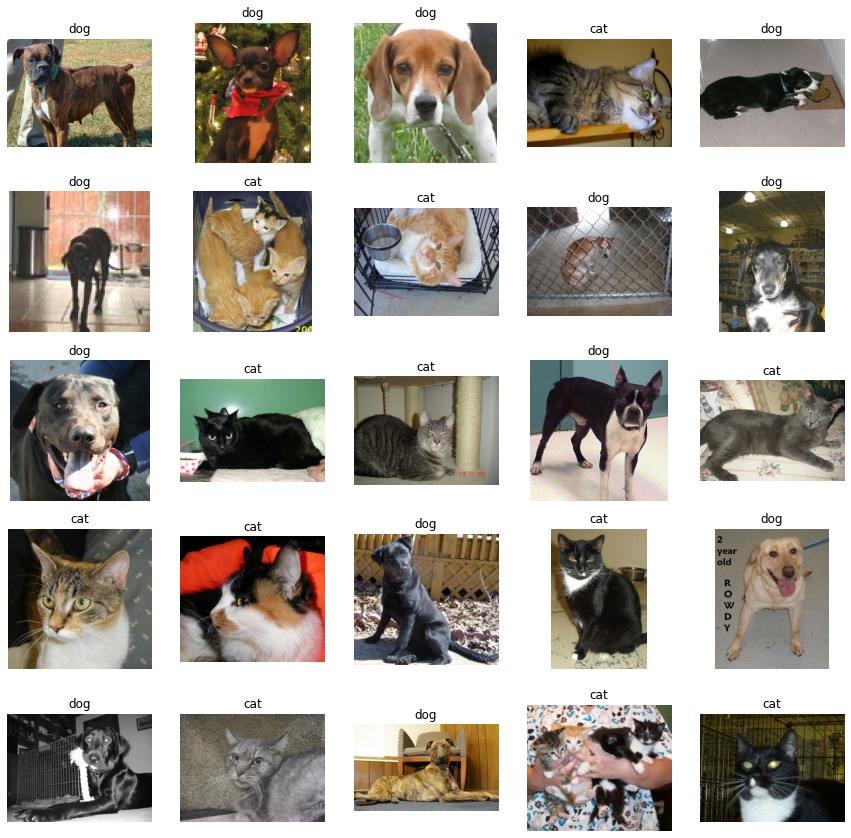

In [12]:
plt.figure(figsize=(15,15))
for i,datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax =plt.subplot(5,5, i+1)
  plt.imshow(datapoint['image'])
  plt.title(class_names[datapoint['label']])
  plt.axis('off')
plt.show()  

In [20]:
N_epochs=5
BATCH_SIZE=128
BUFFER_SIZE=1000
IMAGE_SHAPE=[180,180]
NUM_CLASSES = dataset.info.features["label"].num_classes

In [14]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [17]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.36192906>

In [18]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [21]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

In [22]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

94781440/94765736 [==============================] - 2s 0us/step


In [23]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
STEPS_PER_EPOCH = int(dataset.info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(dataset.info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [27]:
history = model.fit(
    train_dataset,
    epochs = N_epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
145/145 [==============================] - 2324s 16s/step - loss: 0.2676 - accuracy: 0.9319 - val_loss: 0.0506 - val_accuracy: 0.9792
Epoch 2/5
145/145 [==============================] - 2242s 16s/step - loss: 0.0849 - accuracy: 0.9673 - val_loss: 0.0478 - val_accuracy: 0.9818
Epoch 3/5
145/145 [==============================] - 2260s 16s/step - loss: 0.0631 - accuracy: 0.9759 - val_loss: 0.0481 - val_accuracy: 0.9813
Epoch 4/5
145/145 [==============================] - 2243s 15s/step - loss: 0.0529 - accuracy: 0.9806 - val_loss: 0.0456 - val_accuracy: 0.9809
Epoch 5/5
145/145 [==============================] - 2256s 16s/step - loss: 0.0398 - accuracy: 0.9866 - val_loss: 0.0487 - val_accuracy: 0.9787
